# Week 2: Tackle Overfitting with Data Augmentation

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Convolutional_Neural_Networks_in_TensorFlow/Week2/Labs/C2W2_Assignment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

Welcome to this assignment! As in the previous week, you will be using the famous `cats vs dogs` dataset to train a model that can classify images of dogs from images of cats. For this, you will create your own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities, more so this time around since Keras provides excellent support for augmenting image data.

You will also need to create the helper functions to move the images around the filesystem as you did last week, so if you need to refresh your memory with the `os` module be sure to take a look a the [docs](https://docs.python.org/3/library/os.html).

Let's get started!

_**NOTE:** To prevent errors from the autograder, please avoid editing or deleting non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and refrain from adding any new cells._

Download the dataset from its original source by running the cell below.

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [1]:
%%bash

# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

mkdir data
wget -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip -O ./data/cats-and-dogs.zip

In [2]:
import os
import zipfile
import random
import shutil
from keras import layers, utils, Sequential, Input, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2024-06-12 20:49:09.037808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
local_zip = './data/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("./data/")
zip_ref.close()

Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [4]:
source_path = './data/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find ./data/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


**Expected Output:**

```
There are 12500 images of dogs.
There are 12500 images of cats.
```

You will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_val_dirs` below:

In [5]:
# Define root directory
root_dir = './data/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
    """
    Creates directories for the train and test sets

    Args:
        root_path (string) - the base directory path to create subdirectories from

    Returns:
        None
    """
    ### START CODE HERE

    # HINT:
    # Use os.makedirs to create your directories with intermediate subdirectories
    # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

    os.makedirs(os.path.join(root_path, 'training'))
    os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
    os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
    os.makedirs(os.path.join(root_path, 'validation'))
    os.makedirs(os.path.join(f'{root_path}/validation', 'dogs'))
    os.makedirs(os.path.join(f'{root_path}/validation', 'cats'))
    ### END CODE HERE

try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [6]:
# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./data/cats-v-dogs/validation
./data/cats-v-dogs/training
./data/cats-v-dogs/validation/cats
./data/cats-v-dogs/validation/dogs
./data/cats-v-dogs/training/cats
./data/cats-v-dogs/training/dogs


**Expected Output (directory order might vary):**

``` txt
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs

```

Code the `split_data` function which takes in the following arguments:
- SOURCE_DIR: directory containing the files

- TRAINING_DIR: directory that a portion of the files will be copied to (will be used for training)

- VALIDATION_DIR: directory that a portion of the files will be copied to (will be used for validation)

- SPLIT_SIZE: determines the portion of images used for training.

The files should be randomized, so that the training set is a random sample of the files, and the validation set is made up of the remaining files.

For example, if `SOURCE_DIR` is `PetImages/Cat`, and `SPLIT_SIZE` is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING_DIR` directory
and 10% of the images will be copied to the `VALIDATION_DIR` directory.

All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then your function should print out a message such as `"filename is zero length, so ignoring."`. **You should perform this check before the split so that only non-zero images are considered when doing the actual split.**


Hints:

- `os.listdir(DIRECTORY)` returns a list with the contents of that directory.

- `os.path.getsize(PATH)` returns the size of the file

- `copyfile(source, destination)` copies a file from source to destination

- `random.sample(list, len(list))` shuffles a list

In [7]:
# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    """
    Splits the data into train and test sets

    Args:
        SOURCE_DIR (string): directory path containing the images
        TRAINING_DIR (string): directory path to be used for training
        VALIDATION_DIR (string): directory path to be used for validation
        SPLIT_SIZE (float): proportion of the dataset to be used for training

    Returns:
        None
    """

    ### START CODE HERE
    # Shuffle list
    shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

    # Find total number of files in training dir
    training_number = int(len(shuffled_source) * SPLIT_SIZE)

    i = 0
    target = TRAINING_DIR

    for item in shuffled_source:
        item_source = os.path.join(SOURCE_DIR, item)

        try:
            img_bytes = tf.io.read_file(item_source)
            decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as err:
            print(f'{item} is corrupted, so ignoring.')
            continue

        # if os.path.getsize(item_source) == 0:
        #     print(f'{item} is zero length, so ignoring.')
        if len(decoded_img.shape) != 3:
            print(f'{item} has not 3 channels, so ignoring.')
        else:
            shutil.copyfile(item_source, os.path.join(target, item))
            i += 1

        # Switch copy target to TESTING
        if i == training_number:
            target = VALIDATION_DIR
    ### END CODE HERE

In [8]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "./data/PetImages/Cat/"
DOG_SOURCE_DIR = "./data/PetImages/Dog/"

TRAINING_DIR = "./data/cats-v-dogs/training/"
VALIDATION_DIR = "./data/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)

if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)

if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
    for file in os.scandir(VALIDATION_CATS_DIR):
        os.remove(file.path)

if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
    for file in os.scandir(VALIDATION_DOGS_DIR):
        os.remove(file.path)

# Define proportion of images used for training
split_size = 0.9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

2024-06-12 20:49:18.342719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1671 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


10125.jpg has not 3 channels, so ignoring.
2663.jpg has not 3 channels, so ignoring.


Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


9565.jpg has not 3 channels, so ignoring.


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


3300.jpg has not 3 channels, so ignoring.
4833.jpg has not 3 channels, so ignoring.
10501.jpg has not 3 channels, so ignoring.
10404.jpg is corrupted, so ignoring.


2024-06-12 20:49:21.768640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.


666.jpg is corrupted, so ignoring.


2024-06-12 20:49:22.055529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is empty.


7978.jpg has not 3 channels, so ignoring.
3491.jpg has not 3 channels, so ignoring.


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


11565.jpg has not 3 channels, so ignoring.
11935.jpg has not 3 channels, so ignoring.
660.jpg has not 3 channels, so ignoring.
850.jpg has not 3 channels, so ignoring.
936.jpg has not 3 channels, so ignoring.
9171.jpg has not 3 channels, so ignoring.
5553.jpg has not 3 channels, so ignoring.
8470.jpg has not 3 channels, so ignoring.
7968.jpg has not 3 channels, so ignoring.
4351.jpg is corrupted, so ignoring.
140.jpg has not 3 channels, so ignoring.


2024-06-12 20:49:31.009205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input size should match (header_size + row_size * abs_height) but they differ by 2


11210.jpg has not 3 channels, so ignoring.
10820.jpg has not 3 channels, so ignoring.
9778.jpg has not 3 channels, so ignoring.
11874.jpg has not 3 channels, so ignoring.
11702.jpg is corrupted, so ignoring.


2024-06-12 20:49:34.133118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is empty.
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


5736.jpg has not 3 channels, so ignoring.
11912.jpg is corrupted, so ignoring.


2024-06-12 20:49:34.853285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Number of channels inherent in the image must be 1, 3 or 4, was 2


7112.jpg has not 3 channels, so ignoring.
10747.jpg has not 3 channels, so ignoring.
5604.jpg has not 3 channels, so ignoring.
11410.jpg has not 3 channels, so ignoring.
11233.jpg is corrupted, so ignoring.


2024-06-12 20:49:38.777294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Number of channels inherent in the image must be 1, 3 or 4, was 2


11853.jpg has not 3 channels, so ignoring.
8730.jpg has not 3 channels, so ignoring.
7459.jpg has not 3 channels, so ignoring.
3288.jpg has not 3 channels, so ignoring.
9500.jpg is corrupted, so ignoring.


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
2024-06-12 20:49:40.659638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Number of channels inherent in the image must be 1, 3 or 4, was 2


9188.jpg has not 3 channels, so ignoring.
6238.jpg has not 3 channels, so ignoring.


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


2877.jpg has not 3 channels, so ignoring.
7369.jpg has not 3 channels, so ignoring.
2688.jpg has not 3 channels, so ignoring.
11675.jpg has not 3 channels, so ignoring.
2317.jpg is corrupted, so ignoring.


2024-06-12 20:49:43.228181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Number of channels inherent in the image must be 1, 3 or 4, was 2
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


10158.jpg has not 3 channels, so ignoring.
1866.jpg has not 3 channels, so ignoring.


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


3136.jpg has not 3 channels, so ignoring.
7969.jpg has not 3 channels, so ignoring.
10401.jpg has not 3 channels, so ignoring.
10797.jpg has not 3 channels, so ignoring.
7133.jpg has not 3 channels, so ignoring.
3588.jpg has not 3 channels, so ignoring.
2384.jpg has not 3 channels, so ignoring.


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


4367.jpg has not 3 channels, so ignoring.
6059.jpg has not 3 channels, so ignoring.
2494.jpg is corrupted, so ignoring.


2024-06-12 20:49:50.067660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input size should match (header_size + row_size * abs_height) but they differ by 2


6718.jpg has not 3 channels, so ignoring.
11849.jpg has not 3 channels, so ignoring.


Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308.jpg has not 3 channels, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1225 images of cats for validation
There are 1215 images of dogs for validation


**Expected Output:**

```
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation
```

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows you to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **For this exercise use a `target_size` of (150, 150)**.

In [9]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Creates the training and validation data generators

    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images

    Returns:
        train_generator, validation_generator - tuple containing the generators
    """
    ### START CODE HERE

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    scale = layers.Rescaling(scale=1. / 255)

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = utils.image_dataset_from_directory(directory=TRAINING_DIR,
                                                         image_size=(150, 150),
                                                         label_mode='binary')
    
    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    
    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = utils.image_dataset_from_directory(directory=VALIDATION_DIR,
                                                              image_size=(150, 150),
                                                              label_mode='binary')
    
    train_generator = train_generator.map(lambda image, label: (scale(image), label))
    validation_generator = validation_generator.map(lambda image, label: (scale(image), label))
    ### END CODE HERE
    
    return train_generator, validation_generator

In [10]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22500 files belonging to 2 classes.
Found 2440 files belonging to 2 classes.


**Expected Output:**

```
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
```


One last step before training is to define the architecture of the model that will be trained.

Complete the `create_model` function below which should return a Keras' `Sequential` model.

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is compatible with the `class_mode` you defined in the previous exercise, which should also be compatible with the output of your network. You can tell if they aren't compatible if you get an error during training.

**Note that you should use at least 3 convolution layers to achieve the desired performance.**

In [11]:
# GRADED FUNCTION: create_model
def create_model():
    # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
    # USE AT LEAST 3 CONVOLUTION LAYERS

    ### START CODE HERE

    augmentation = Sequential([layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                               layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                               layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                               layers.RandomFlip(mode="horizontal")])

    model = Sequential([Input(shape=(150, 150, 3)),
                        augmentation,
                        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
                        layers.Conv2D(32, (3, 3), activation='relu'),
                        layers.MaxPooling2D(2, 2),
                        layers.Conv2D(64, (3, 3), activation='relu'),
                        layers.MaxPooling2D(2, 2),
                        layers.Conv2D(128, (3, 3), activation='relu'),
                        layers.MaxPooling2D(2, 2),
                        layers.Conv2D(128, (3, 3), activation='relu'),
                        layers.MaxPooling2D(2, 2),
                        # Flatten the results to feed into a DNN
                        layers.Flatten(),
                        # 512 neuron hidden layer
                        layers.Dense(512, activation='relu'),
                        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
                        layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    ### END CODE HERE

    return model

Now it is time to train your model!

Note: You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [12]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=20,
                    verbose=2,
                    validation_data=validation_generator)

Epoch 1/20


2024-06-12 20:49:55.964179: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 36s - 51ms/step - accuracy: 0.5626 - loss: 0.6821 - val_accuracy: 0.6738 - val_loss: 0.6181
Epoch 2/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 31s - 43ms/step - accuracy: 0.6409 - loss: 0.6322 - val_accuracy: 0.5742 - val_loss: 0.7129
Epoch 3/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.6784 - loss: 0.5991 - val_accuracy: 0.6783 - val_loss: 0.5983
Epoch 4/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.6977 - loss: 0.5781 - val_accuracy: 0.5861 - val_loss: 0.8313
Epoch 5/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.7200 - loss: 0.5547 - val_accuracy: 0.7008 - val_loss: 0.5527
Epoch 6/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.7357 - loss: 0.5320 - val_accuracy: 0.8012 - val_loss: 0.4395
Epoch 7/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.7514 - loss: 0.5117 - val_accuracy: 0.7131 - val_loss: 0.5662
Epoch 8/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.7651 - loss: 0.4929 - val_accuracy: 0.7709 - val_loss: 0.5244
Epoch 9/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 31s - 43ms/step - accuracy: 0.7815 - loss: 0.4704 - val_accuracy: 0.7193 - val_loss: 0.5576
Epoch 10/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 31s - 43ms/step - accuracy: 0.7876 - loss: 0.4565 - val_accuracy: 0.8156 - val_loss: 0.4111
Epoch 11/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.8016 - loss: 0.4399 - val_accuracy: 0.7689 - val_loss: 0.4828
Epoch 12/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.8067 - loss: 0.4274 - val_accuracy: 0.8631 - val_loss: 0.3275
Epoch 13/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.8162 - loss: 0.4095 - val_accuracy: 0.8082 - val_loss: 0.4199
Epoch 14/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.8233 - loss: 0.3970 - val_accuracy: 0.8303 - val_loss: 0.3821
Epoch 15/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.8299 - loss: 0.3837 - val_accuracy: 0.7570 - val_loss: 0.6575
Epoch 16/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 31s - 43ms/step - accuracy: 0.8352 - loss: 0.3782 - val_accuracy: 0.8754 - val_loss: 0.3063
Epoch 17/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 31s - 43ms/step - accuracy: 0.8401 - loss: 0.3681 - val_accuracy: 0.8615 - val_loss: 0.3479
Epoch 18/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 30s - 43ms/step - accuracy: 0.8405 - loss: 0.3632 - val_accuracy: 0.8713 - val_loss: 0.3112
Epoch 19/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 31s - 43ms/step - accuracy: 0.8448 - loss: 0.3589 - val_accuracy: 0.8443 - val_loss: 0.3874
Epoch 20/20


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


704/704 - 31s - 44ms/step - accuracy: 0.8483 - loss: 0.3482 - val_accuracy: 0.8852 - val_loss: 0.2932


Once training has finished, you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

**To pass this assignment, your model should achieve a training and validation accuracy of at least 80% and the final testing accuracy should be either higher than the training one or have a 5% difference at maximum**. If your model didn't achieve these thresholds, try training again with a different model architecture, remember to use at least 3 convolutional layers or try tweaking the image augmentation process.

You might wonder why the training threshold to pass this assignment is significantly lower compared to last week's assignment. Image augmentation does help with overfitting but usually this comes at the expense of requiring more training time. To keep the training time reasonable, the same number of epochs as in the previous assignment are kept.

However, as an optional exercise you are encouraged to try training for more epochs and to achieve really good training and validation accuracies.

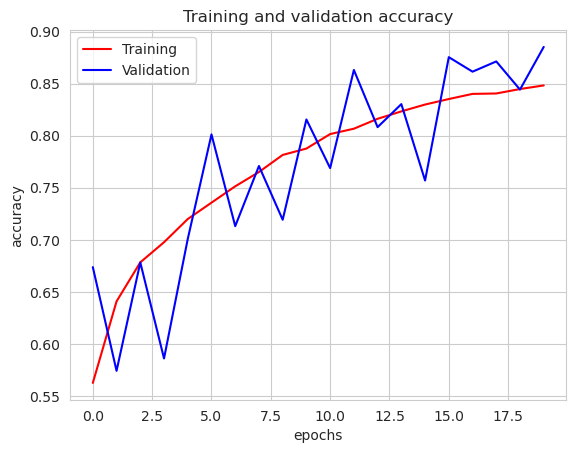

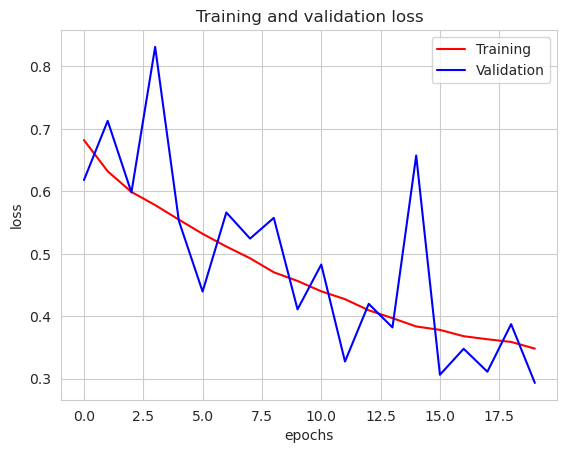

In [13]:
sns.set_style("whitegrid")

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["Training", "Validation"])
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Training", "Validation"])
plt.show()

You will probably encounter that the model is overfitting, which means that it is doing a great job at classifying the images in the training set but struggles with new data. This is perfectly fine and you will learn how to mitigate this issue in the upcomming week.

Before closing the assignment, be sure to also download the `history.pkl` file which contains the information of the training history of your model. You can download this file by running the cell below:

## Download your notebook for grading

Along with the `history.pkl` file, you will also need to submit your solution notebook for grading. The following code cells will check if this notebook's grader metadata (i.e. hidden data in the notebook needed for grading) is not modified by your workspace. This will ensure that the autograder can evaluate your code properly. Depending on its output, you will either:

* *if the metadata is intact*: Download the current notebook. Click on the File tab on the upper left corner of the screen then click on `Download -> Download .ipynb.` You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.
<br>

* *if the metadata is missing*: A new notebook with your solutions will be created on this Colab workspace. It should be downloaded automatically and you can submit that to the grader.

In [14]:
!rm -rf ./data

**Please disregard the following note if the notebook metadata is detected**

_Note: Just in case the download fails for the second point above, you can also do these steps:_
* _Click the Folder icon on the left side of this screen to open the File Manager._
* _Click the Folder Refresh icon in the File Manager to see the latest files in the workspace. You should see a file ending with a `_fixed.ipynb`._
* _Right-click on that file to save locally and submit it to the grader._


**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that classifies images of cats and dogs, along with the helper functions needed to pre-process the images!

**Keep it up!**